This notebook is for self-learning in FewShot Learning. The ideas and original repository is from this link [Easy Few-Shot Learning](https://github.com/sicara/easy-few-shot-learning).

What did I learn throughout this notebook.
- Get to know PyTorch library.
- Import dataset from torchvision library
- Applying transfer learning to use the model which is already pre-built and trained.
- Learn the ideas of Few-Shot Learning using the concept of Prototypical Network model.

Installing the [easyfsl](https://github.com/sicara/easy-few-shot-learning/tree/master/easyfsl) GitHub repository

In [ ]:
#Installing the easyfsl GitHub repository
!pip install easyfsl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.8/72.8 kB 3.1 MB/s eta 0:00:00


#IMPORTING

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from tqdm import tqdm
from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

#DATA-PREPROCESSING

We use Omniglot (avalable in the torchvision library) dataset, which is a popular MNIST dataset for the FewShot or any Computer Vision models.

In [ ]:
#Image resizing
transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])

#Load Omniplot dataset
omniglot_train = datasets.Omniglot(
    root='./data',
    download=True,
    background=True,
    transform=transform
)

omniglot_test = datasets.Omniglot(
    root='./data',
    download=True,
    background=True,
    transform=transform
)

100%|██████████| 9464212/9464212 [00:00<00:00, 180910675.54it/s]

Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


Files already downloaded and verified


In [ ]:
omniglot_train

Dataset Omniglot
    Number of datapoints: 19280
    Root location: ./data/omniglot-py
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

#DEFINE THE MODEL

We are using the Pytorch nn.Module to build a backbone

In [ ]:
class PrototypicalNetworks(nn.Module):
  def __init__(self, backbone):
    super(PrototypicalNetworks, self).__init__()
    self.backbone = backbone

  #Forward pass
  def forward(self, support_images, support_labels, query_images):
    #Features from support and query images
    z_support = self.backbone(support_images)
    z_query = self.backbone(query_images)

    #Infer the number of labels (N-way) from support labels
    n_way = len(torch.unique(support_labels))

    #Compute class prototypes
    z_proto = torch.cat([
        z_support[torch.nonzero(support_labels == label)].mean(0)
        for label in range(n_way)
    ])

    #Compute how far each query feature is from each class prototype using Euclidean distance
    dists = torch.cdist(z_query, z_proto)

    #Transform into scores that facilitate classification.
    scores = -dists
    return scores

For the backbone of CNN model, I apply transfer learning to use the ResNet18 to deploy the model.

In [ ]:
#Define the backbone CNN model (using Resnet18)
backbone = resnet18(pretrained=False)
# Change the first convolutional layer to accept 1 channel
backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
backbone.fc = nn.Flatten()
model = PrototypicalNetworks(backbone)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


#TRAIN THE MODEL

In [ ]:
#Preparing for backpropergation (defining the optimizer, loss function)
optimizer = optim.Adam(model.parameters(), lr=0.00005)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
#Define hyperparameters
n_episodes = 10000  # Number of episodes to train
n_way = 5  # Number of classes per episode
n_shot = 5  # Number of examples per class in the support set (few-shot)
n_query = 15  # Number of query examples per class

Custom DataLoader with TaskSampler:
Imported from https://github.com/sicara/easy-few-shot-learning/blob/master/easyfsl/samplers/task_sampler.py

In [ ]:
# Define the get_labels function
omniglot_train.get_labels = lambda: [instance[1] for instance in omniglot_train._flat_character_images]
omniglot_test.get_labels = lambda: [instance[1] for instance in omniglot_test._flat_character_images]

In [ ]:
# Define a TaskSampler to sample tasks (episodes) from the dataset
train_sampler = TaskSampler(omniglot_train, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_episodes)
test_sampler = TaskSampler(omniglot_test, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=n_episodes)

In [ ]:
#Load the training dataset
train_loader = DataLoader(omniglot_train, batch_sampler=train_sampler, collate_fn=train_sampler.episodic_collate_fn)
len(next(iter(train_loader)))

5

Basic Training

In [ ]:
# Basic training loop
for episode, (support_images, support_labels, query_images, query_labels, _) in enumerate(train_loader):
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear previous gradients

    # Forward pass: compute the model's predictions (scores) for the query set
    scores = model(support_images, support_labels, query_images)

    # Compute the loss between predicted scores and query labels
    loss = loss_fn(scores, query_labels)

    # Backward pass: compute gradients
    loss.backward()

    # Update model weights
    optimizer.step()

    if episode % 100 == 0:
        print(f"Episode {episode}/{n_episodes} - Loss: {loss.item()}")

print("Training completed.")

Episode 0/10000 - Loss: 1.1574009656906128
Episode 100/10000 - Loss: 0.30183181166648865
Episode 200/10000 - Loss: 0.13500691950321198
Episode 300/10000 - Loss: 0.11862116307020187
Episode 400/10000 - Loss: 0.054970189929008484
Episode 500/10000 - Loss: 0.052240192890167236
Episode 600/10000 - Loss: 0.37174469232559204
Episode 700/10000 - Loss: 0.10586836189031601
Episode 800/10000 - Loss: 0.134413480758667
Episode 900/10000 - Loss: 0.12874376773834229
Episode 1000/10000 - Loss: 0.02268327958881855
Episode 1100/10000 - Loss: 0.10292050987482071
Episode 1200/10000 - Loss: 0.05121014639735222
Episode 1300/10000 - Loss: 0.02922356314957142
Episode 1400/10000 - Loss: 0.02346927300095558
Episode 1500/10000 - Loss: 0.02748497948050499
Episode 1600/10000 - Loss: 0.03317911550402641
Episode 1700/10000 - Loss: 0.03724118322134018
Episode 1800/10000 - Loss: 0.1106511801481247
Episode 1900/10000 - Loss: 0.04878043010830879
Episode 2000/10000 - Loss: 0.010418114252388477
Episode 2100/10000 - Loss:

#EVALUATE THE MODEL

In [ ]:
#Load the tessting data
test_loader = DataLoader(omniglot_test, batch_sampler=test_sampler, collate_fn=train_sampler.episodic_collate_fn)

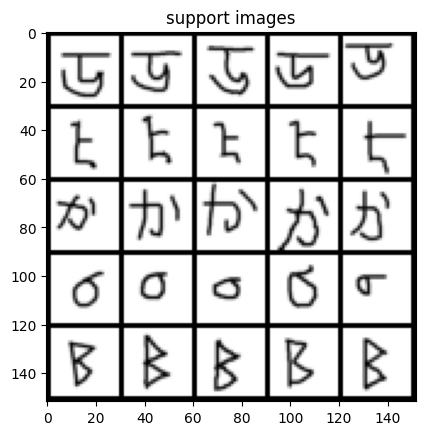

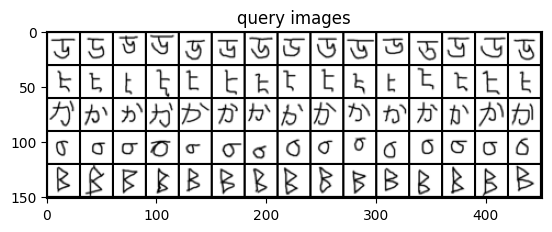

In [ ]:
#Indicate some support and query images - Displaying in a grid
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))

plot_images(example_support_images, "support images", images_per_row=n_shot)
plot_images(example_query_images, "query images", images_per_row=n_query)

In [ ]:
#Evaluate the model
def evaluate(data_loader: DataLoader):
    #Counting the predictions:
    total_predictions = 0
    correct_predictions = 0

    """
    ---PyTorch---
    model.eval(): Switches the model to evaluation mode, affecting layers like dropout and batch normalization.
    torch.no_grad(): Temporarily disables gradient calculations, saving memory and computation during inference.
    """
    model.eval()
    with torch.no_grad():
        for episode, (support_images, support_labels, query_images, query_labels, _) in enumerate(tqdm(data_loader)):
            # Forward pass: compute the model's predictions (scores) for the query set
            scores = model(support_images, support_labels, query_images).detach()
            _, predicted_labels = torch.max(scores.data, 1)

            total_predictions += query_labels.size(0)
            correct_predictions += (predicted_labels == query_labels).sum().item()
        print(f"Model tested on {len(data_loader)} tasks. Accuracy: {(100 * correct_predictions/total_predictions):.2f}%")

In [ ]:
evaluate(test_loader)

100%|██████████| 10000/10000 [53:44<00:00,  3.10it/s]

Model tested on 10000 tasks. Accuracy: 98.80%


In [ ]:
torch.save(model.state_dict(), 'model1.pth')

In [ ]:
torch.load('/content/drive/MyDrive/ML/FewShotLearning/model.pth')

<ipython-input-18-d747881426fa>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load('/content/drive/MyDrive/ML/FewShotLearning/model.pth')


OrderedDict([('backbone.conv1.weight',
              tensor([[[[-6.6034e-02,  8.2387e-02, -1.4366e-02,  ...,  4.1376e-02,
                         -7.0617e-02, -7.4630e-02],
                        [-9.2544e-02, -9.6019e-02,  1.7724e-02,  ...,  3.3896e-02,
                          9.5460e-02,  1.4592e-02],
                        [-8.8966e-02,  7.5548e-02, -3.9183e-02,  ...,  7.3365e-02,
                         -1.2130e-01, -1.2159e-01],
                        ...,
                        [-1.1713e-01, -4.0844e-02, -1.1101e-01,  ..., -7.8319e-02,
                         -4.3300e-02,  5.6083e-03],
                        [-4.0882e-04,  6.4289e-02,  5.0823e-02,  ...,  1.3445e-02,
                         -1.1809e-01, -5.6904e-02],
                        [-1.2203e-01,  5.7826e-02, -9.1948e-02,  ..., -7.1262e-02,
                         -1.2382e-01, -8.9584e-02]]],
              
              
                      [[[-8.7356e-02,  9.5409e-02, -2.8941e-02,  ...,  6.7324e-02,
       